In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from pathlib import Path
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import glob
import contextlib
from PIL import Image
plt.rcParams['figure.dpi'] = 300
data_path = Path("../../GetData/Python/Data")

2024-03-22 07:09:22.405850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model

In [2]:
class CVAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, num_classes,  kernel_size = 3):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
     )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim+num_classes,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size,strides=(1, 1),padding="SAME",activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="SAME"),
        ]
    )

  def call(self, inputs):
    image, temp = inputs
    mean, logvar = self.encode(image)
    z = self.reparameterize(mean, logvar)
    z = tf.concat([z, temp], axis=1)
    reconstructed = self.decode(z)
    return reconstructed

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  image, temp = x
  mean, logvar = model.encode(image)
  z = model.reparameterize(mean, logvar)
  z_t = tf.concat([z, temp], axis=1)
  x_logit = model.decode(z_t)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=image)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training

In [3]:
def plot_spins(path, predictions, originals):
    fig = plt.figure(figsize=(15, 20))
    subfigs = fig.subfigures(nrows=len(predictions), ncols=1)
    images, temps = originals
    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Sample nr: {index}')
        axs = subfig.subplots(nrows=1, ncols=4)

        axs[0].imshow(predictions[index, :, :, 0], vmin=0, vmax=1)
        axs[0].axis('off')
        axs[0].set_title("Spin +1 probability map")

        axs[1].imshow(np.random.binomial(1, predictions[index, :, :, 0]), vmin=0, vmax=1)
        axs[1].axis('off')
        axs[1].set_title("Predicted from binomial")

        axs[2].imshow(predictions[index, :, :, 0] > 0.5, vmin=0, vmax=1)
        axs[2].axis('off')
        axs[2].set_title("p > 0.5")

        axs[3].imshow(images[index, :, :, 0], vmin=0, vmax=1)
        axs[3].axis('off')
        axs[3].set_title("Original Sample")

    plt.savefig(path)
    plt.show()

def generate_and_save_images(model, epoch, test_sample, results):
  predictions = make_prediction(model, test_sample)
  plot_spins(results / "Images" / f'image_at_epoch_{epoch}.png', predictions, test_sample)

def make_prediction(model, test_sample):
    images, temps = test_sample
    mean, logvar = model.encode(images)
    z = model.reparameterize(mean, logvar)
    z = tf.concat([z, temps], axis=1)
    predictions = model.sample(z)
    return predictions

def cost_function_plot(loss_list, results):
  plt.figure()
  plt.suptitle("Loss function vs Epoch - CVAE")
  plt.plot(loss_list)
  plt.xlabel("Epoch")
  plt.ylabel("Cost function")
  plt.savefig(results / "loss_function.png")


# Dataset

In [4]:
class DataIterator:
    def __init__(self, datasets):
        self.datasets = datasets

    def __iter__(self):
        self.data_iterators = [iter(data) for data in self.datasets]
        return self
        
    def plus_encode_data(self, data):
        data = tf.reshape(data, shape=(data.shape[0], -1))
        mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
        need_change = tf.cast(mean_data < 0.5, data.dtype)
        data = data * (1 - 2 * need_change) + need_change
        data = tf.reshape(data, shape=(-1, 32, 32, 1))
        return data   
        
    def __next__(self):
        data_list = []
        temp_list = []
        for index, data_iterator in enumerate(self.data_iterators):
            data = next(data_iterator)
            data_list.append(data)
            temp = np.zeros((data.shape[0], len(self.data_iterators)))
            temp[:, index] = 1
            temp_list.append(temp)
        temps = tf.concat(temp_list, axis=0)
        data = tf.concat(data_list, axis=0)
        data = self.plus_encode_data(data)
        return data, temps

In [5]:
import tensorflow as tf
from input_pipeline import dataset_tfrecord_pipeline
from pathlib import Path

def make_dataset(data_dir, temps, batch_size=100, flatten=False):
    if isinstance(data_dir, str):
        data_dir = Path(data_dir)

    assert batch_size % len(temps) == 0, "Batch size must be divisible by the number of temperatures"

    trainset = []
    testset = []
    for temp in temps:
        dataset = dataset_tfrecord_pipeline(data_dir / f"Dataset{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        trainset.append(dataset)
        dataset = dataset_tfrecord_pipeline(data_dir / f"TestData{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        testset.append(dataset)

    gen_test = DataIterator(testset)
    test_dataset = tf.data.Dataset.from_generator(lambda: gen_test, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, len(temps)), dtype=tf.float32)))
    gen_train = DataIterator(trainset)
    train_dataset = tf.data.Dataset.from_generator(lambda: gen_train, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, len(temps)), dtype=tf.float32)))
    return train_dataset, test_dataset

In [6]:
def load_starting_weights(model, temps):
    dummy_image = tf.zeros((1, 32, 32, 1))
    dummy_temp = tf.zeros(shape = (1, len(temps)), dtype = tf.float32)
    dummy_input = (dummy_image, dummy_temp)
    model(dummy_input)
    model.load_weights(data_path / "Results" / "cvae" / "reference" / "cvae.h5")

In [7]:
from IPython import display
from time import time
from queue import Queue
from input_pipeline import dataset_tfrecord_pipeline
from datetime import datetime

def train(temps, batch_size = 100, epochs = 50, latent_dim = 200, num_examples_to_generate = 5, test_size = 50, dataset = None):
  # Folders for storing the results and dataset
  current_datetime = datetime.now()
  formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")
  results = data_path / "Results" / "cvae" / formatted_datetime
  results.mkdir()
  (results / "Images").mkdir()

  # Model and optimizer
  optimizer = tf.keras.optimizers.Adam(1e-4)
  model = CVAE(latent_dim, len(temps))
  loss_monitor = 3 * [False]

  # Dataset
  if dataset is None:
    load_starting_weights(model, temps)
    dataset = make_dataset(data_path, temps, batch_size = batch_size)
      
  trainset, testset = dataset

  # Test sample for image generation
  assert batch_size >= num_examples_to_generate
  for image, temps in testset.take(1):
    image_sample = image[0:num_examples_to_generate, :, :, :]
    temp_sample = temps[0:num_examples_to_generate, :]
    test_sample = (image_sample, temp_sample)
  #generate_and_save_images(model, 0, test_sample, results)

  # Training loop
  loss_list = []
  for epoch in range(1, epochs + 1):
    time_start = time()
    for train_x in trainset:
      train_step(model, train_x, optimizer)
    loss = tf.keras.metrics.Mean()
    for test_x in testset:
      loss(compute_loss(model, test_x))

    elbo = -loss.result()
    loss_list.append(loss.result().numpy())

    if epoch > 1:
      loss_monitor.pop(-1)
      loss_monitor.insert(0, loss_list[-1] - loss_list[-2] > 0)
      if all(loss_monitor):
        print("STOP!")
        break

    #display.clear_output(wait=False)
    #generate_and_save_images(model, epoch, test_sample, results)
    elapsed = time() - time_start
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, Time needed: {elapsed}')

  cost_function_plot(loss_list, results)
  model.save_weights(results / f'cvae.h5',save_format='h5')

## Train

In [8]:
temps = [1.5, 2.0, 2.5, 2.7, 3.0, 4.0]
epochs = 15
latent_dim = 200
num_examples_to_generate = 5
batch_size = 240

2024-03-22 07:09:26.860119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11551 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1
2024-03-22 07:09:27.429039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-22 07:09:31.870169: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2af84d747000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 07:09:31.870231: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2024-03-22 07:09:31.876672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 07:09:32.019789: I ./tensorflow/compiler/jit/device_compiler.h:186] Compile

Epoch: 1, Test set ELBO: -439.0008239746094, Time needed: 296.21694707870483
Epoch: 2, Test set ELBO: -426.5611877441406, Time needed: 345.59342098236084
Epoch: 3, Test set ELBO: -421.1036376953125, Time needed: 320.51018738746643
Epoch: 4, Test set ELBO: -417.80340576171875, Time needed: 322.12347984313965
Epoch: 5, Test set ELBO: -415.7041015625, Time needed: 321.1713695526123
Epoch: 6, Test set ELBO: -414.3957214355469, Time needed: 323.3349549770355
Epoch: 7, Test set ELBO: -413.3304443359375, Time needed: 321.1824290752411
Epoch: 8, Test set ELBO: -412.5419616699219, Time needed: 321.8106393814087
Epoch: 9, Test set ELBO: -411.7569885253906, Time needed: 322.2083261013031
Epoch: 10, Test set ELBO: -411.193603515625, Time needed: 322.83866000175476
Epoch: 11, Test set ELBO: -410.73126220703125, Time needed: 261.0227544307709
Epoch: 12, Test set ELBO: -410.54388427734375, Time needed: 321.38964891433716
Epoch: 13, Test set ELBO: -410.03338623046875, Time needed: 161.32053995132446
E

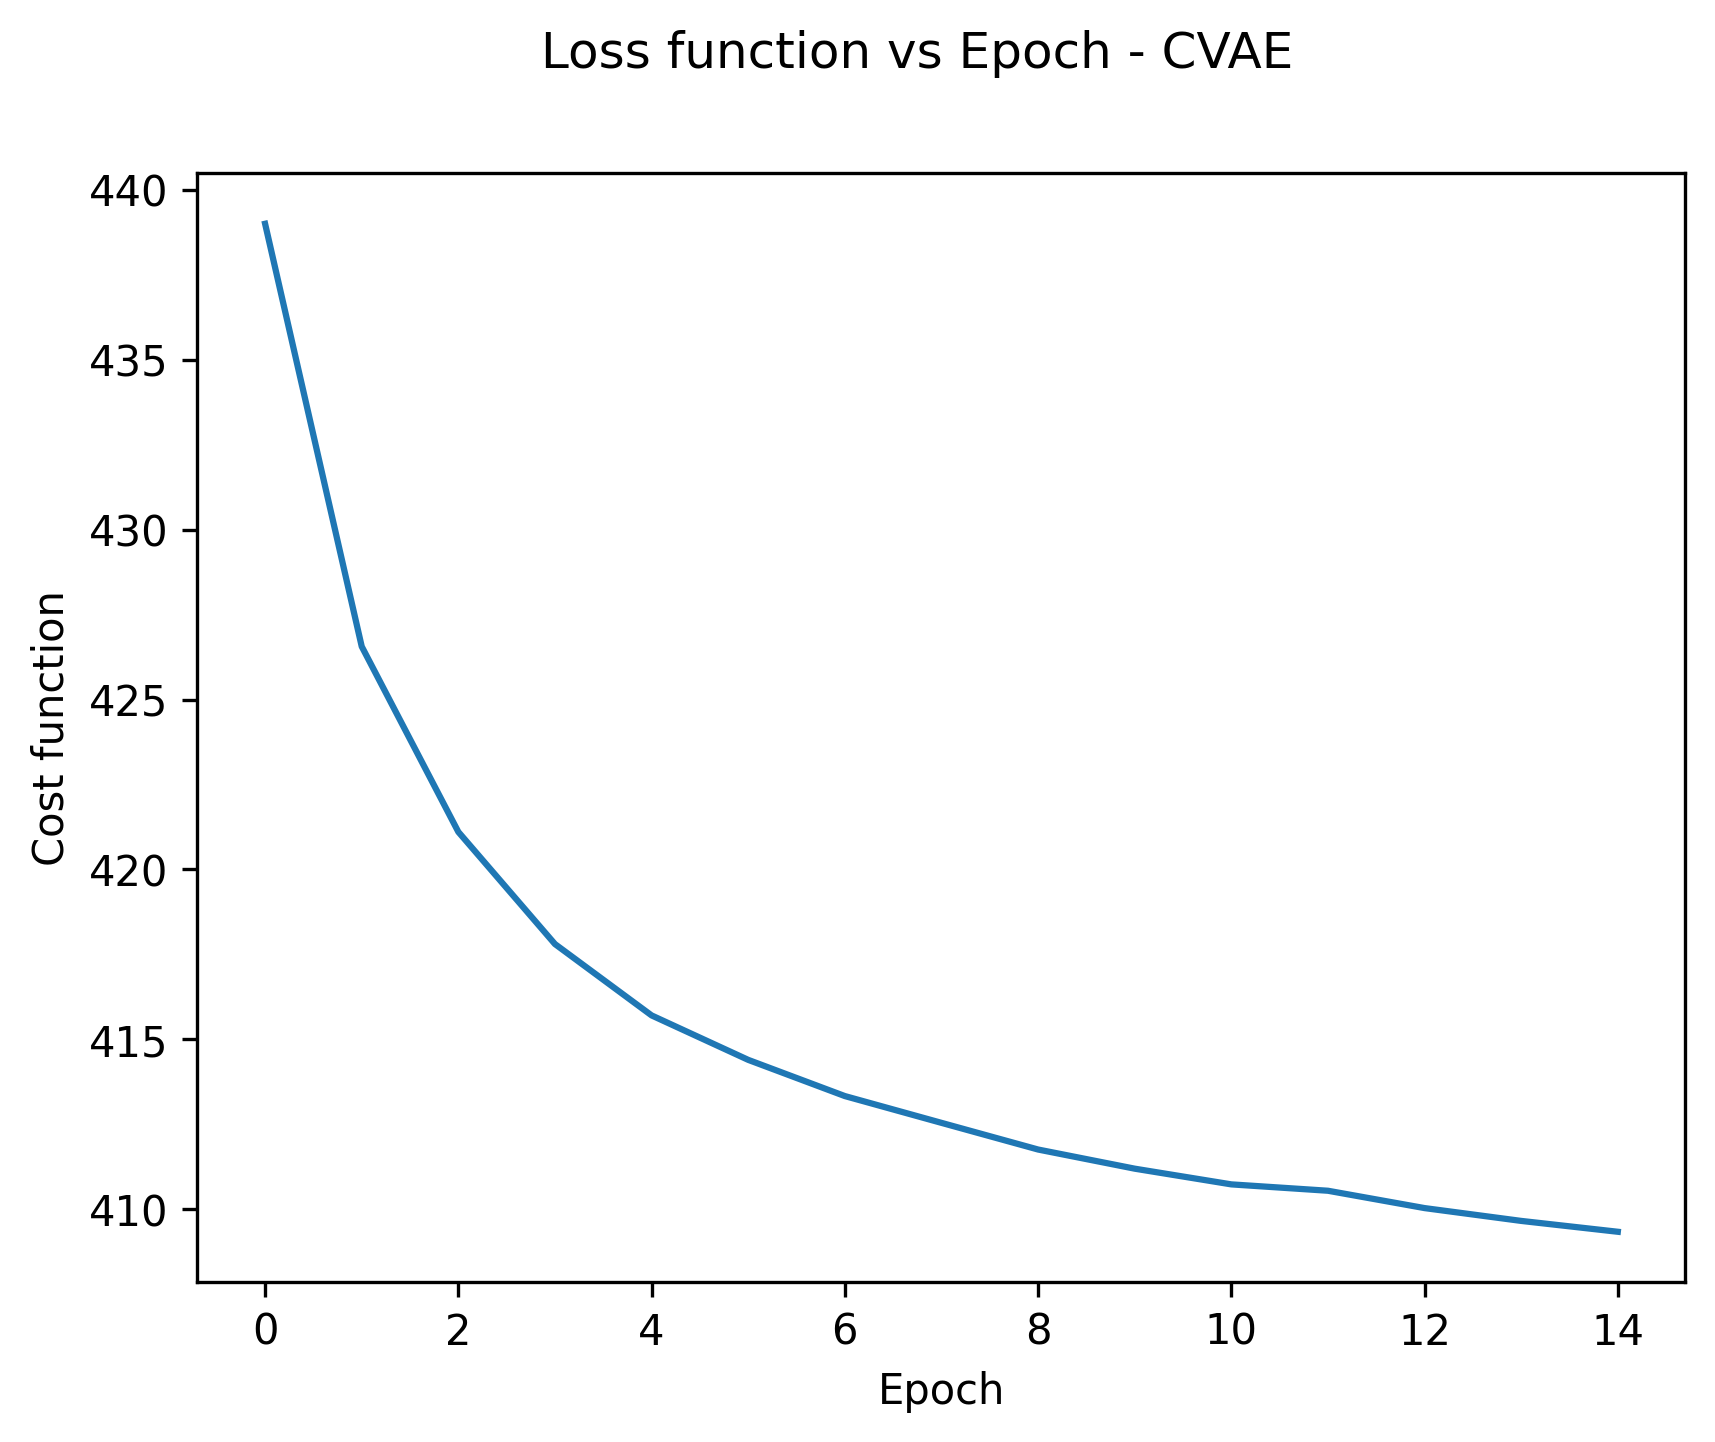

In [9]:
train(
    temps = temps,
    batch_size = batch_size,
    epochs = epochs,
    latent_dim = latent_dim,
    num_examples_to_generate = num_examples_to_generate,
    test_size = 100,
)

## Refrence weights

In [9]:
batch_size = 120
train_1 = dataset_tfrecord_pipeline(data_path / f"Data1.5.tfrecord", flatten=False, batch_size=int(batch_size/3))
train_2 = dataset_tfrecord_pipeline(data_path / f"Data2.0.tfrecord", flatten=False, batch_size=int(batch_size/3))
test_1 = dataset_tfrecord_pipeline(data_path / f"TestData1.5.tfrecord", flatten=False, batch_size=int(batch_size/3))
test_2 = dataset_tfrecord_pipeline(data_path / f"TestData2.0.tfrecord", flatten=False, batch_size=int(batch_size/3))

def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   
        
def dataset_generator(dataset_1, dataset_2, temp_vectors):
  for image_batch_1, image_batch_2 in zip(dataset_1, dataset_2):
    temp_vector = tf.concat(temp_vectors, axis = 0)
    image_batch = tf.concat((image_batch_1, image_batch_2), axis = 0)
    image_batch = plus_encode_data(image_batch)
    yield image_batch, temp_vector

temp_vector_1 = np.zeros(shape = (int(batch_size/3), len(temps)))
temp_vector_1[0] = 1
temp_vector_2 = np.zeros(shape = (int(batch_size/3), len(temps)))
temp_vector_2[1] = 1

gen_train = dataset_generator(train_1, train_2, (temp_vector_1, temp_vector_2))
gen_test = dataset_generator(test_1, test_2, (temp_vector_1, temp_vector_2))

trainset = tf.data.Dataset.from_generator(lambda: gen_train, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, len(temps)), dtype=tf.float32)))
testset = tf.data.Dataset.from_generator(lambda: gen_test, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, len(temps)), dtype=tf.float32)))

2024-03-21 07:31:50.504719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11551 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1


2024-03-21 07:32:00.622624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-21 07:32:01.248756: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b60362662e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 07:32:01.248820: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2024-03-21 07:32:01.255074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-21 07:32:01.397328: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 1, Test set ELBO: -115.6912612915039, Time needed: 27.798851013183594


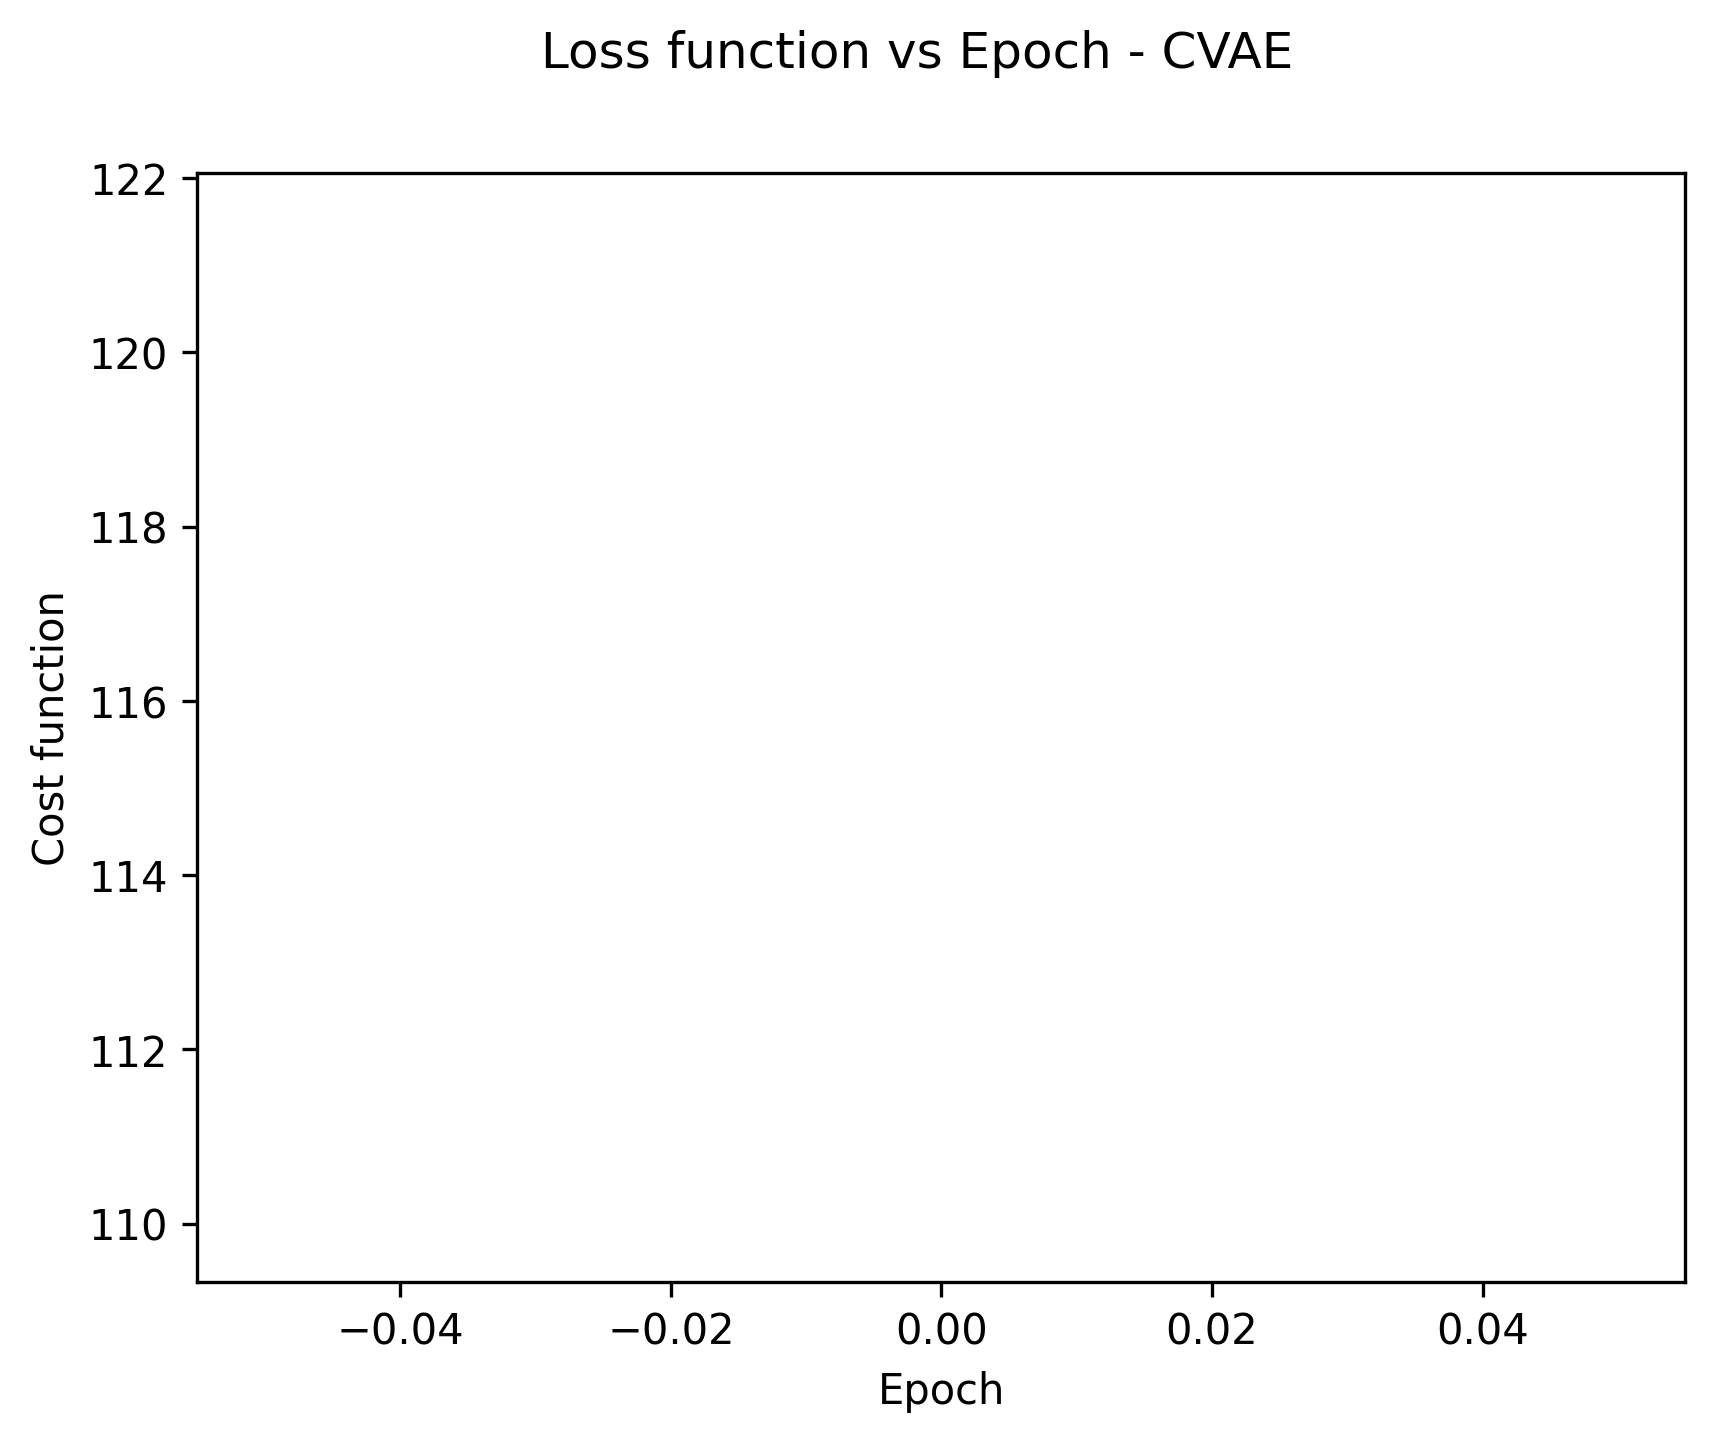

In [10]:
train(
    temps = temps,
    batch_size = batch_size,
    epochs = 1,
    latent_dim = latent_dim,
    num_examples_to_generate = num_examples_to_generate,
    test_size = 100,
    dataset = (trainset, testset)
)